In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.utils import shuffle
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score

In [2]:
N = 3  # dimension of vector X

In [3]:
class1 = np.random.normal(1.5, 2.5, size=(N, 1000))
class2 = np.concatenate([np.random.normal(-4, 1.5, size=(N, 500)), np.random.normal(10, 1.5, size=(N, 500))], 1)

In [4]:
def plot_3d(classes, figsize=(7, 7)):
    """
    Plots points in 3d space
    :param classes: list with 2 arrays with points corresponded to different classes
    :param figsize: plot size
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    z1, x1, y1 = classes[0]
    z2, x2, y2 = classes[1]
    ax.scatter(z1, y1, z1, alpha=1, color='coral')
    ax.scatter(z2, y2, z2, alpha=1, color='green')
    plt.show()

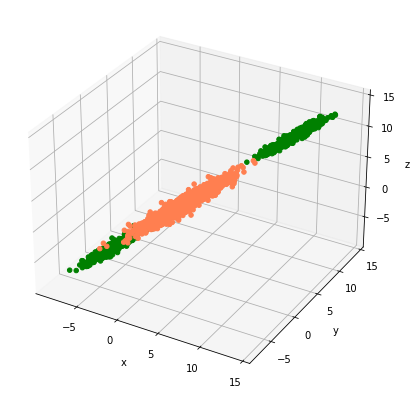

In [5]:
plot_3d([class1, class2])

In [6]:
columns_names = ['x{}'.format(i) for i in range(N)]
df1 = pd.DataFrame(class1.T, columns = [*columns_names])
df1['target'] = 0
df2 = pd.DataFrame(class2.T, columns = [*columns_names])
df2['target'] = 1

In [7]:
df = df1.append(df2)
df

,x0,x1,x2,target
0,4.871205,0.845508,-1.857713,0
1,2.102502,-1.030975,0.347019,0
2,-6.401079,2.884871,2.034082,0
3,1.777608,-0.509349,1.398716,0
4,3.482192,3.478385,2.460995,0
...,...,...,...,...
995,9.457081,12.604843,8.550399,1
996,9.055958,6.895054,9.770136,1
997,9.829917,9.986762,12.503062,1
998,9.880399,7.675917,12.813296,1


In [8]:
def data_shuffle(data):
    data_shuffled = shuffle(data, random_state=42)
    X = data_shuffled.drop('target', 1)
    y = data_shuffled['target']
    return data_shuffled, X, y

In [9]:
df_shuffle, X, y = data_shuffle(df)

In [10]:
df_shuffle

,x0,x1,x2,target
860,9.600725,11.678089,8.050728,1
353,0.797261,2.286198,2.559601,0
333,-2.633060,-0.523831,-3.137531,1
905,0.073866,1.548602,0.898420,0
289,-5.111298,-2.859117,-3.849259,1
...,...,...,...,...
130,-4.722572,-0.224708,-7.498250,1
294,-5.288168,-3.060775,-3.380410,1
860,5.543824,3.792059,0.597932,0
459,-2.030991,-4.662867,-3.516970,1


In [11]:
X_new = X.values
y_new = y.values

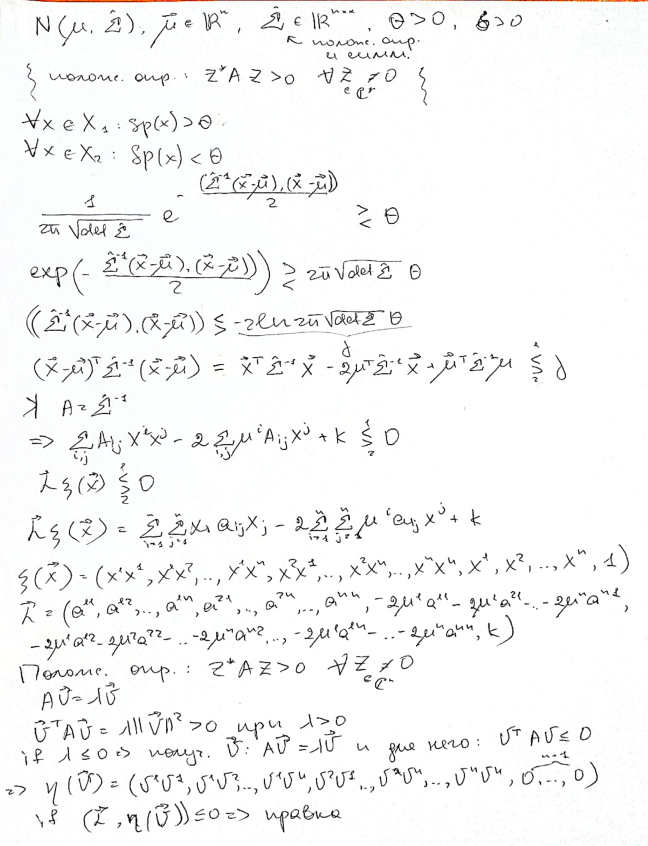

In [12]:
class Perceptron():

    def __init__(self, n_iter=100):
        """
        Constructs class instance
        :param n_iter: number of the iterations
        """
    
        self.n_iter = n_iter
        self.alpha = 0
    
    @staticmethod
    def vectors_transformation(vector):
        """
        Transforms vector (ksi) to appropriate form according to specific rule
        :param vector: vector to be transformed
        :return: transformed vector
        """
        vector_ = np.einsum('i,j->ij', vector, vector).ravel()
        vector_ = np.concatenate((vector_, vector, [1]))
        return vector_
    
    @staticmethod
    def eig_vector_transformation(vector):
        """
        Transforms eigen vector (eta) to appropriate form according to specific rule
        :param vector: vector to be transformed
        :return: transformed vector
        """
        vector_ = np.einsum('i,j->ij', vector, vector).ravel()
        vector_ = np.concatenate((vector_, np.zeros(len(vector)+1)))
        return vector_

    def check_eig(self, alpha, dim=N):
        """
        Finds eigen vectors and their transformed versions. Also finds a product between alphas and transformed eigen vectors
        :param alpha: transformed vector from initial properties
        :param dim: dimension of the X
        :return: array with products of alphas and transformed eigen vectors, array with transformed eigen vectors
        """
        A = np.reshape(a=alpha[:dim**2], newshape=(dim, dim))
        v, l = np.linalg.eig(A)
        count = len(l)
        l_all = [l[:, i] for i in range(count)]
        eta_l = [self.eig_vector_transformation(l_all[i]) for i in range(count)]
        alpha_eta_l = [np.dot(self.alpha, eta_l[i]) for i in range(count)]
        return alpha_eta_l, eta_l 

    def fit(self, X, y):
        """
        Training process
        :param X: array with x values to be trained on
        :param y: array with target classes
        """
        self.alpha = np.zeros(N**2+N+1)
        for i in range(self.n_iter):
            j = 0
            for xi, target in zip(X, y):
                ksi_i = self.vectors_transformation(xi)
                alpha_ksi = np.dot(self.alpha, ksi_i)
                
                if alpha_ksi >= 0 and target == 1:
                        self.alpha -= ksi_i
                elif alpha_ksi <= 0 and target == 0:
                        self.alpha += ksi_i
                        
                alpha_eta_l, eta_l = self.check_eig(self.alpha)
                for i in range(len(alpha_eta_l)):
                    if alpha_eta_l[i] <= 0:
                        self.alpha = self.alpha + eta_l[i]
                j += 1   
                        
    def input_values(self, X):
        """
        Finds product between alpha and X
        :param X: array with x values
        :return: array with values corresponded to product between alpha and X
        """
        return np.dot(X, self.alpha)

    def predict(self, X):
        """
        Function to predict target values
        :param X: array with x values to predict on
        :return: array with predicted target values
        """
        ksi_pred = np.zeros((X.shape[0], N**2+N+1))
        k = 0
        for xi in X:
            ksi_pred_i = self.vectors_transformation(xi)
            ksi_pred[k] = ksi_pred_i
            k += 1
        return np.where(self.input_values(ksi_pred) >= 0.0, 0, 1)

In [13]:
perceptron = Perceptron(n_iter=100)

In [14]:
perceptron.fit(X_new, y_new)

In [15]:
prediction = perceptron.predict(X_new)

In [16]:
accuracy_score(prediction, y_new)

0.9945

In [17]:
idx_0 = np.where(prediction == 0)
idx_1 = np.where(prediction == 1)

In [18]:
class1_predict = X_new[idx_0[0]].T
class2_predict = X_new[idx_1[0]].T

In [19]:
class2_predict.shape

(3, 1001)

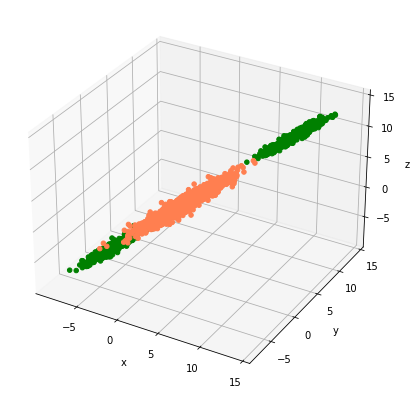

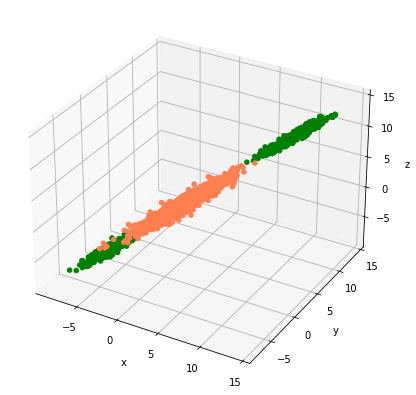

In [20]:
plot_3d([class1, class2]) # original values
plot_3d([class1_predict, class2_predict]) # predicted values